# Introduction to NASA `earthaccess`

**Summary**

[`earthaccess`](https://github.com/nsidc/earthaccess) is a Python library that provides a unified and reproducible approach to find and access NASA Earth science data. It handles authentication, and provides an efficient way to search [NASA Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/) and access the data via bulk download or direct access. Specifically, this notebook demonstrates how to search for NASA Earth science data collections and data using the `earthaccess` package.

A NASA Earthdata Login account ([EDL](https://urs.earthdata.nasa.gov/profile)) is required to download or access data. Earthdata Login accounts are free and can be set up in only a few minutes. Remember your EDL username and password as they are needed for authentication in this and other data access resources.

**Requirements**  

- A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required.   
- A compatible Python environment. Please see the [Python setup instructions](https://github.com/nasa/LPDAAC-Data-Resources/blob/main/setup/setup_instructions_python.md) to create a compatible local environment.

**Learning Objectives**  

- How to search data collections using a keyword with `earthaccess`
- How to search for data using spatiotemporal parameters
- How to work with `earthaccess` request objects
- How do direct access or download data

**Contents**

1. [Setup](#setup)
2. [Authentication](#auth)
3. [Searching for Datasets AKA Collections](#collections)
4. [Searching for Data AKA Granules](#granules)
5. [Working with Search Results](#results)
6. [Downloading and Streaming Data](#download)

## 1. Setup <a name="setup"></a>

Let's start by loading the required packages. If you need to set up a local Python environment, please see the [Python setup instructions](https://github.com/nasa/LPDAAC-Data-Resources/blob/main/setup/setup_instructions_python.md) to create a compatible environment.  

In [2]:
import earthaccess
import os
import pandas as pd
import geopandas as gp
from shapely.geometry.polygon import orient
import hvplot.pandas

import rioxarray as rxr
import rasterio as rio
import hvplot.xarray


## 2. Authentication <a name="auth"></a>

`earthaccess` creates and leverages Earthdata Login tokens to authenticate with NASA systems. Earthdata Login tokens expire after a month, but `earthaccess` will refresh these for you. To retrieve a token from Earthdata Login, you can either enter your username and password each time you use `earthaccess`, or use a `.netrc` file. A `.netrc` file is a configuration file that is commonly used to store login credentials for remote systems. If you don't have a `.netrc` or don't know if you have one or not, you can use the `persist` argument with the `login` function below to create or update an existing one, then use it for authentication.

If you do not have an Earthdata Account, you can [create one](https://urs.earthdata.nasa.gov/home).

In [3]:
auth = earthaccess.login(persist = True)
# are we authenticated?
print(auth.authenticated)

True


## 3. Searching for Datasets, AKA Collections <a name="collections"></a>

We need information about the collection or dataset we're interested in before we can do an effective search for data. We'll use the `search_datasets()` function with the `keyword` and `provider` arguments to query for collections that match. The provider argument isn't necessary, but if you know which DAAC hosts data you can provide this to further filter results.

In [4]:
collections = earthaccess.search_datasets(
    provider='LPCLOUD',    # LPCLOUD is the LP DAAC Archive in Earthdata Cloud
    keyword='ecostress',
)
# Print Quantity of Results
print(f'Collections found: {len(collections)}')

Collections found: 50


Results from `search_datasets` are returned as enhanced python dictionaries (`DataCollections` class) which, can be interacted with like any Python dictionary. Let's take a look at the first collection in our returned `collections`.

In [5]:
collection = collections[0]

In [6]:
collection.keys()

dict_keys(['meta', 'umm'])

In [7]:
collection['umm'].keys()

dict_keys(['TilingIdentificationSystems', 'CollectionCitations', 'AdditionalAttributes', 'SpatialExtent', 'CollectionProgress', 'StandardProduct', 'ScienceKeywords', 'TemporalExtents', 'ProcessingLevel', 'DOI', 'ShortName', 'EntryTitle', 'DirectDistributionInformation', 'AccessConstraints', 'RelatedUrls', 'DataDates', 'Abstract', 'Purpose', 'LocationKeywords', 'MetadataDates', 'VersionDescription', 'Version', 'Projects', 'UseConstraints', 'ContactPersons', 'CollectionDataType', 'DataCenters', 'TemporalKeywords', 'Platforms', 'MetadataSpecification', 'ArchiveAndDistributionInformation'])

In [8]:
collection['umm']['ShortName']

'ECO_L2T_LSTE'

The `DataCollections` class also has some handy helper methods.

```python 
collection.concept_id() # returns the concept-id, used to search for data granules
collection.abstract() # returns the abstract
collection.landing_page() # returns the landing page if present in the UMM fields
collection.get_data() # returns the portal where data can be accessed.
```

The same results can be obtained using the `dict` syntax:

```python
collection["meta"]["concept-id"] # concept-id
collection["umm"]["RelatedUrls"] # URLs, with GET DATA, LANDING PAGE etc
```


Another helpful method is `summary()`. This method prints some of the more common collection metadata information used for additional queries against the individual collection.

In [9]:
collection.summary()

{'short-name': 'ECO_L2T_LSTE',
 'concept-id': 'C2076090826-LPCLOUD',
 'version': '002',
 'file-type': "[{'Format': 'COG', 'FormatType': 'Native', 'Media': ['Earthdata Cloud', 'HTTPS'], 'AverageFileSize': 7.3, 'AverageFileSizeUnit': 'MB', 'TotalCollectionFileSizeBeginDate': '2018-07-09T00:00:00.000Z', 'FormatDescription': 'Cloud Optimized GeoTIFF (COG)'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C2076090826-LPCLOUD',
  'https://appeears.earthdatacloud.nasa.gov/'],
 'cloud-info': {'Region': 'us-west-2',
  'S3BucketAndObjectPrefixNames': ['s3://lp-prod-protected/ECO_L2T_LSTE.002',
   's3://lp-prod-public/ECO_L2T_LSTE.002'],
  'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
  'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME'}}

The most common way to query for information or metadata related to a collection is to use the **concept-id**, the collection **doi**, or a combination of both the **short-name** and **version**. The `summary()` method gives us the **concept-id**, **short-name**, and **version**. We can use this knowledge to create a list containing this information for later queries against the specific collections.

In [10]:
collections_info = [
    {
        'short_name': c.summary()['short-name'],
        'collection_concept_id': c.summary()['concept-id'],
        'version': c.summary()['version'],
        'entry_title': c['umm']['EntryTitle']
    }
    for c in collections
]
# Preview First Collection
collections_info[0]

{'short_name': 'ECO_L2T_LSTE',
 'collection_concept_id': 'C2076090826-LPCLOUD',
 'version': '002',
 'entry_title': 'ECOSTRESS Tiled Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002'}

We can also turn this into a dataframe for easy visualization.

In [11]:
# Preview as a dataframe
pd.set_option('display.max_colwidth', 150)
pd.DataFrame(collections_info)

,short_name,collection_concept_id,version,entry_title
0,ECO_L2T_LSTE,C2076090826-LPCLOUD,002,ECOSTRESS Tiled Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
1,ECO_L1B_GEO,C2076087338-LPCLOUD,002,ECOSTRESS Swath Geolocation Instantaneous L1B Global 70 m V002
2,ECO_L2_LSTE,C2076114664-LPCLOUD,002,ECOSTRESS Swath Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
3,ECO_L2_CLOUD,C2076115306-LPCLOUD,002,ECOSTRESS Swath Cloud Mask Instantaneous L2 Global 70 m V002
4,ECO_L3T_JET,C2076106409-LPCLOUD,002,ECOSTRESS Tiled Evapotranspiration Instantaneous and Daytime L3 Global 70 m V002
5,ECO_L2T_STARS,C2090073749-LPCLOUD,002,ECOSTRESS Tiled Ancillary NDVI and Albedo L2 Global 70 m V002
6,ECO_L1CT_RAD,C2595678301-LPCLOUD,002,ECOSTRESS Tiled Top of Atmosphere Calibrated Radiance Instantaneous L1C Global 70 m V002
7,ECO_L4T_ESI,C2076104650-LPCLOUD,002,ECOSTRESS Tiled Evaporative Stress Index PT-JPL Instantaneous L4 Global 70 m V002
8,ECO_L2G_LSTE,C2076113037-LPCLOUD,002,ECOSTRESS Gridded Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
9,ECO_L4G_ESI,C2076110703-LPCLOUD,002,ECOSTRESS Gridded Evaporative Stress Index PT-JPL Instantaneous L4 Global 70 m V002


## 4. Searching for Granules <a name="granules"></a>

A `granule` can be thought of as a unique spatiotemporal grouping within a collection. To search for `granules`, we can use the `search_data` function from `earthaccess` and provide the arguments for our search based on the collection information we retrieved above. Its possible to specify search products using several criteria shown in the table below:

|dataset origin and location|spatio temporal parameters|dataset metadata parameters|
|:---|:---|:---|
|archive_center|bounding_box|concept_id
|data_center|temporal|entry_title
|daac|point|granule_name
|provider|polygon|version
|cloud_hosted|line|short_name

In this example, we will use the **short_name** and the **version** to query for data granules from [`ECO_L2T_LSTE`](https://doi.org/10.5067/ECOSTRESS/ECO_L2_LSTE.002) version `002` dataset. You can search data granules using just a **short_name** but there is the potential that multiple versions of the data collection will be return. To query for granules in a more explicit way, a **concept-id** would be the best option.  

In [12]:
# We build our query
granules_request = earthaccess.search_data(
    short_name='ECO_L2T_LSTE',
    version='002',
    provider='LPCLOUD',
    count=1
)
print(f'Granules found: {len(granules_request)}')

Granules found: 1


Without our **count** argument used to restrict the quantity of results, this query would have returned a lot of granules, over 13 million, and taken a long time to complete. Let's refine our search using **bounding box** and **temporal** arguments as constraints.

### Spatiotemporal queries

The `earthaccess.results.DataGranule` and `earthaccess.results.DataCollection` classes accept the same spatial and temporal arguments as CMR, so we can search for granules that match spatiotemporal criteria.

#### Specifying Spatial Parameters

Search queries can be refined by using spatial parameters. `earthaccess` accepts point and area arguments. For point features a longitude and latitude coordinate pair must be passes as a tuple to the `point` parameter. For example:

```
point = (-105.64788824641289,39.98286247719818)
```

For area features, queries can leverage the `bounding_box` or a `polygon`.

The `bounding_box` argument accepts a tuple containing coordinates in the order lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat:

```
bbox = (-105.58650854045227, 40.05184049311418, -105.5832945453711, 40.05424331298521)
```

For this example we'll use a `polygon` for a spatial parameter.


The `polygon` argument accepts a list of vertices in counter-clockwise order:

```
polygon = [(-105.58501133091315, 40.05184049311418),
 (-105.5832945453711, 40.053984736232714),
 (-105.58351661636773, 40.05424331298521),
 (-105.5839952821831, 40.05403439678874),
 (-105.5864783735272, 40.05234816435479),
 (-105.58650854045227, 40.052056831297655),
 (-105.58559965168544, 40.051883708267695),
 (-105.58501133091315, 40.05184049311418)]

```
This list or the bbox can be retrieved from a geojson or shapefile easily using the steps below.

Open a **geojson** file and visualize it to understand our region of interest.

In [13]:
geojson = gp.read_file('../../data/NIWO_box.geojson')

In [14]:
geojson_plot = geojson.hvplot(tiles='ESRI', color='yellow', alpha=0.5, crs='EPSG:4326')
geojson_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

A **shapefile** can also be opened similarly.

In [15]:
shp = gp.read_file('../../data/NIWO_ShrubDensity.shp')

In [16]:
shp_plot = shp.hvplot(tiles='ESRI', color='blue', alpha=0.5, crs='EPSG:4326')
geojson_plot * shp_plot

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .WMTS.II     :WMTS   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

We can get the bounding box that encompasses all of the features using the `total_bounds` method and pass it to the `bounding_box` parameter in our search query.  

In [17]:
bbox = tuple(list(shp.total_bounds))
bbox

(np.float64(-105.58650854045227),
 np.float64(40.05184049311418),
 np.float64(-105.5832945453711),
 np.float64(40.05424331298521))

Retrieving the `polygon` can be done also, but we need to ensure the vertices are in counter-clockwise order. For this example we actually have 4 geometries, so we can either search for each polygon, which can be beneficial in some scenarios, or create a convex hull around them to get the smallest spatial area including all 4, which we will do here.

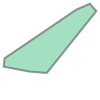

In [18]:
# Convex Hull 
shp_ch = shp.union_all().convex_hull
shp_ch

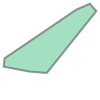

In [19]:
polygon = orient(shp_ch, sign=1.0)
polygon

In [ ]:
# List the exterior coordinates
polygon_coords = list(polygon.exterior.coords)    # Replace polygon with shp_ch for shapefile
polygon_coords

[(-105.58501133091315, 40.05184049311418),
 (-105.58559965168544, 40.051883708267695),
 (-105.58650854045227, 40.052056831297655),
 (-105.5864783735272, 40.05234816435479),
 (-105.5839952821831, 40.05403439678874),
 (-105.58351661636773, 40.05424331298521),
 (-105.5832945453711, 40.053984736232714),
 (-105.58501133091315, 40.05184049311418)]

We can now use this as our `polygon` in the search.

#### Specify Temporal Parameters  

To specify the date and time period we are interested in, we pass a tuple containing the start and end datetime in ISO-8601 format (YYYY-MM-DDTHH:mm:ss). We can stop at any increment and the rest will be autocompleted. Examples: `2023-05-01T12:15:30.000`, `2023-05-01T12:15`, or `2023-05-01`

In [100]:
dates = ('2023-05-01','2023-09-30')    # tuple containing the start and end date

In [101]:
results = earthaccess.search_data(
    short_name='ECO_L2T_LSTE',
    version='002',
    provider='LPCLOUD',
    polygon=polygon_coords,
    temporal=dates,
)
# Print Quantity of Results
print(f'Granules found: {len(results)}')

Granules found: 172


If we wanted to perform a query for a point or bounding_box, we would only need to swap out the `polygon` parameter for the `point` or `bounding_box` parameter.

> **Note that we are limiting our results to a count of 100.**

Additionally, a `granule_name` argument can be used to filter based on the names of the granules. This is handy for tiled datasets like the one we're working with, ECOSTRESS L2T LSTE, which uses the [Harmonized Landsat Sentinel-2 tiling system](https://hls.gsfc.nasa.gov/products-description/tiling-system/). This argument can also be used for other tiled datasets like MODIS or VIIRS, or any other string contained in the granule name. We can specify a tile, like below, using asterisks to indicate a wildcard on either side of the specified string.

In [102]:
tile_results = earthaccess.search_data(
    short_name='ECO_L2T_LSTE',
    version='002',
    provider='LPCLOUD',
    granule_name='*13TDE*',
    temporal=dates)
# Print Quantity of Results
print(f'Granules found: {len(tile_results)}')

Granules found: 172


## 5. Working with Search Results <a name="results"></a>

Similarly to our search for collections, our search for granules is returned as an enhanced python dictionary, so we can interact with them in the same ways. 

In [103]:
print(f'results is a {type(results)} of {type(results[0])}')

results is a <class 'list'> of <class 'earthaccess.results.DataGranule'>


Let's look at the first granule from our bounding box query.  

In [104]:
granule = results[0]

Since we are in a notebook we can take advantage of it to see a more user friendly version of the granules by calling the object or using the built-in function `display`.  

In [105]:
granule

Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -106.18317260659883, 'EastBoundingCoordinate': -104.88503005879925, 'NorthBoundingCoordinate': 40.65079928293903, 'SouthBoundingCoordinate': 39.65611291096908}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-03T07:50:20.492Z', 'EndingDateTime': '2023-05-03T07:51:12.462Z'}}
Size(MB): 18.35
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_height.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_QC.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_LST.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_LST_err.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_EmisWB.tif']

In [106]:
# Display multiple granules
[display(granule) for granule in granules_request[0:2]]

Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -66.2315157579371, 'EastBoundingCoordinate': -64.62679179812478, 'NorthBoundingCoordinate': -49.57282585197919, 'SouthBoundingCoordinate': -50.60506189697378}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-07-09T21:13:12.461Z', 'EndingDateTime': '2018-07-09T21:14:04.431Z'}}
Size(MB): 2.41
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_height.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_QC.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_LST.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_LST_err.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01/ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_EmisWB.tif']

[None]

Now inspect the dictionary returned by looking at the different metadata available.

In [107]:
granule.keys()

dict_keys(['meta', 'umm', 'size'])

In [108]:
granule['umm'].keys()

dict_keys(['TemporalExtent', 'OrbitCalculatedSpatialDomains', 'GranuleUR', 'AdditionalAttributes', 'MeasuredParameters', 'SpatialExtent', 'ProviderDates', 'CollectionReference', 'PGEVersionClass', 'RelatedUrls', 'DataGranule', 'Platforms', 'MetadataSpecification'])

The `DataGranule` class returned by our search also has several convenience methods. The `data_links()` method can extract all of the data links associated with each granule. We can specify `access` as `direct` to retrieve S3 links rather than https links.

In [109]:
# access='direct' for s3 links.
granule.data_links(access='indirect')

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_water.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_view_zenith.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_height.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_

Granules for **ECO_L2T_LSTE** are made up of multiple files. This is the case for several of the `LPCLOUD` provider collection. Other collections may only have a single file.  

At this stage, we can take advantage of the `earthaccess.open` function to provide credentials and stream the data, or use `earthaccess.download` to download our result; however, when collections have multiple files per granule, its often helpful to first filter down to only the desired variables. We can see in the list of links above that the dataset has several variables:
- water mask
- cloud mask
- view zenith
- height
- quality
- land surface temperature (LST)
- LST error
- emissivity

If we only want the LST, quality, and cloud mask we can use string matching to only keep those links. 

Before we do this, lets first get all of the links from our results.

In [110]:
links = [granule.data_links() for granule in results]
links[:2]

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_water.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_view_zenith.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_height.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348

Note that this returns a nested list of granules, where each granule has a list of links. We can also flatten this list if we want to work without nesting. 

In [111]:
links = [link for granule in results for link in granule.data_links()]
links[:16]

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_water.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_view_zenith.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_height.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_

Now use string matching to select the variables (links) we want from the list (LST, cloud, QC).

In [112]:
# Define Desired Links/Assets
variables = ['LST.tif','QC.tif','cloud.tif']
# Filter Links
filtered_links = [link for link in links if any(var in link for var in variables)]
# Display first 10 links
filtered_links[:10]

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_QC.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01/ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01_cloud.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01/ECOv002_L2T_LSTE_27352_012_13TDE_202305

## 6. Downloading or Streaming Data <a name="download"></a>

There are two typical routes users can take to access LP DAAC data, Downloading or Streaming.

**Downloading** – This has been a supported option since the inception of NASA's DAACs. Users can use the data link(s) to download files to their local working environment. This method works in both cloud and non-cloud environments.

**Streaming** – Streaming enables on-the-fly reading of remote files (i.e., files not saved locally). However, the accessed data must fit into the workspace’s memory. Streaming works in both cloud and non-cloud environments, although is more performant if in the cloud and the dataset is in a cloud-optimized format. Streaming data stored in the cloud without downloading is called **in-place access or direct S3 access**. This is only available when working in a cloud environment deployed in AWS us-west-2. If outisde the cloud, 


### 6.1 Downloading Data

As mentioned above, the `earthaccess.download` function can be used immediately after results are returned, but this will retrieve all of the files and often we want to filter these down first.

In [113]:
# Download all results from count=1 example above
earthaccess.download(granules_request, local_path='../../data')

QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

['..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_water.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_cloud.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_view_zenith.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_height.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_QC.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_LST.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_LST_err.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_00048_003_19FGE_20180709T211312_0712_01_EmisWB.tif']

We can also pass a list of links to this function. Download the first 6 files from our `filtered_links`.

In [114]:
# Download first 6 links from filtered results
earthaccess.download(filtered_links[:6], local_path='../../data')

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

['..\\..\\data\\ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_cloud.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_QC.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_LST.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01_cloud.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01_QC.tif',
 '..\\..\\data\\ECOv002_L2T_LSTE_27352_012_13TDE_20230503T142012_0710_01_LST.tif']

### 6.2 Streaming Data

There are different approaches for streaming data based upon the filetype or if you are working in-region in the AWS uswest-2 cloud. ECOSTRESS L2T LSTE data are distributed as cloud-optimized geotiff (COG) files, so we'll show an example of streaming COG files with HTTPS links here. Some of our other tutorials have other examples that may be helpful depending on your goals:

- [Streaming COG files with S3 Links](https://github.com/nasa/ECOSTRESS-Data-Resources/blob/main/python/how-tos/how_to_direct_access_s3_ecostress_cog.ipynb)
- [Streaming NetCDF4 files with HTTPS Links](https://github.com/nasa/VITALS/blob/main/python/02_Working_with_EMIT_Reflectance_and_ECOSTRESS_LST.ipynb)
- [Streaming NetCDF4 files with S3 Links](https://github.com/nasa/EMIT-Data-Resources/blob/main/python/how-tos/How_to_Direct_S3_Access.ipynb)
 
The Python libraries used to access COG files in Earthdata Cloud leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the GLanCE30 COG files. For this exercise, we are going to open up a context manager for the notebook using the `rasterio.env` module to store these configurations. The context manager sends this information, including an authentication token or cookie when connecting to a file and can also customize how the file is handled locally. A list of all available config options can be found in the [GDAL config options documentation](https://gdal.org/en/stable/user/configoptions.html).

While the context manager is open (env.enter()) we will be able to run the open or get data commands that would typically be executed within a "with" statement. Entering the context manager for multiple cells of the notebook allows us to more freely interact with the data. We’ll close the context manager (env.exit()) when we have all of the data loaded into memory.

In [115]:
# Set up Context Manager
rio_env = rio.Env(
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    GDAL_HTTP_UNSAFESSL="YES",
    GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
    GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
    GDAL_HTTP_MAX_RETRY="10",
    GDAL_HTTP_RETRY_DELAY="0.5",
)
rio_env.__enter__()

Let's open an LST file. We can quickly grab just the LST links from our `filtered_links`.

In [116]:
lst_links = [link for link in filtered_links if 'LST.tif' in link]
lst_links[0]

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01/ECOv002_L2T_LSTE_27348_005_13TDE_20230503T075020_0711_01_LST.tif'

Now we'll use `rioxarray` to read the first file in our list. `rioxarray` reads the COG file in as an `xarray` `DataArray`. The `mask_and_scale` argument can be used to automatically set fill-values to `np.nan` and apply any scale factor and offsets included in the metadata. When a COG file is read in using `rioxarray`, a **band** dimension is created. In most circumstances this dimension can be removed. We use the `squeeze` function to remove it. 

In [117]:
lst_da = rxr.open_rasterio(filename=lst_links[0], mask_and_scale=True).squeeze('band', drop=True)
lst_da

<xarray.DataArray (y: 1568, x: 1568)> Size: 10MB
[2458624 values with dtype=float32]
Coordinates:
  * x            (x) float64 13kB 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
  * y            (y) float64 13kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

We can make a cursory spatial plot of the data using `hvplot`, reprojecting so it will match basemap tiles. Note that our example shape is very small, so you'll have to zoom in on the center of the scene to see the several small plots from our polygon search.

In [ ]:
size_opts = dict(frame_height=405, frame_width=720, fontscale=1.2)

lst_da.rio.reproject('EPSG:4326').hvplot.image(x='x', y='y', **size_opts, cmap='inferno', tiles='ESRI', crs='EPSG:4326', title=f'{lst_links[0].split('/')[-1]}') * shp.hvplot(color = '#FF000000', crs='EPSG:4326')

## Contact Information  

**Authors:**  LP DAAC¹  
**Contact:** LPDAAC@usgs.gov  
**Voice:** +1-866-573-3222  
**Organization:** Land Processes Distributed Active Archive Center (LP DAAC)  
**Website:** [https://lpdaac.usgs.gov/](https://lpdaac.usgs.gov/)  

¹Work performed under USGS contract G15PD00467 for LP DAAC under NASA contract NNG14HH33I.  